In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import random

In [2]:
## Where are we working
proj_dir = '/Users/zstanley/Documents/git_repos/obs_loc_for_scda'
plot_dir = proj_dir + '/plots'
my_data_dir = proj_dir + '/my_data'
nb_dir = proj_dir + '/notebooks'

In [3]:
cd /Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts

/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts


In [4]:
from letkf import *
from post_processing_fns import *

In [5]:
## Load covariance matrices

# South Pacific
sp_cov = np.load(my_data_dir +'/south_pacific_cov.npy')
sp_cov = sp_cov[64:, 64:]

# Southern Ocean
so_cov = np.load(my_data_dir +'/southern_ocean_cov.npy')
so_cov = so_cov[64:, 64:]

# Indian Ocean
io_cov = np.load(my_data_dir +'/indian_ocean_cov.npy')
io_cov = io_cov[64:, 64:]

In [6]:
## Load correlation matrices

# South Pacific
sp_cor = np.load(my_data_dir +'/south_pacific_cor.npy')
sp_cor = sp_cor[64:, 64:]

# Southern Ocean
so_cor = np.load(my_data_dir +'/southern_ocean_cor.npy')
so_cor = so_cor[64:, 64:]

# Indian Ocean
io_cor = np.load(my_data_dir +'/indian_ocean_cor.npy')
io_cor = io_cor[64:, 64:]

In [7]:
# Load columns to get density
south_pacific = xr.open_dataset(my_data_dir+'/five_columns_south_pacific.nc')
southern_ocean = xr.open_dataset(my_data_dir+'/five_columns_southern_ocean.nc')
indian_ocean = xr.open_dataset(my_data_dir+'/five_columns_indian_ocean.nc')

In [8]:
this_cov = so_cov
this_cov_sqrt = np.linalg.cholesky(this_cov)
this_cor = so_cor
this_ds = southern_ocean
this_short_name = 'so'
this_full_name = 'Southern Ocean'

In [9]:
ind150m = 37
ind500m = 50
ind2km = 67

In [10]:
this_ind = ind2km
inds = np.arange(0, this_ind, 2)
num_inds = len(inds)

In [11]:
this_ds['ocn_Dens'] = dens_wright_eos(this_ds['ocn_Temp'], this_ds['ocn_Salt'], 0)
this_ds['ocn_Dens'].attrs['units'] = 'kg m-3'

In [12]:
ocn_rho = this_ds['ocn_Dens'].mean(['ens_mem', 'lat', 'lon']).to_numpy()

In [13]:
## Get state positions
ocn_z = np.load(my_data_dir+'/ocn_z.npy')

In [14]:
# Compute pairwise distance matrix
def create_distance_matrix(spatial_locations):
    N = len(spatial_locations)
    dis = np.zeros((N,N));
    for jj in range(N):
        for ii in range(N):
            dis[ii, jj] = np.abs(spatial_locations[ii]-spatial_locations[jj])
    return dis    

In [15]:
# Compute pairwise distance matrix
dist_mat = create_distance_matrix(ocn_z[:this_ind])

In [16]:
def compute_analysis_err(observe_this_level, localization_radii, this_cov, this_cov_sqrt, pos_state, ens_size = 20, start=0, stop=37):
    ## Set observation operator
    num_levs = this_cov.shape[0]
    HofX = np.zeros((1, num_levs))
    HofX[0, observe_this_level] = 1
    
    ## Set observation position
    pos_ob = pos_state[observe_this_level]
    
    ## Generate synthetic observations
    xt = this_cov_sqrt @ np.random.normal(size=(num_levs, 1))
    y_ob = HofX @ this_cov_sqrt @ np.random.normal(xt, scale=1, size=xt.shape) # obs error set to equal background error
    
    ## Generate ensemble
    rnd = np.random.normal(size=(num_levs, ens_size))
    x_ens = this_cov_sqrt @ rnd
    P_ens = np.cov(x_ens)
    
    ## Set observation error variance equal to true variance
    R = HofX @ this_cov @ HofX.transpose()
    R_inv = np.reciprocal(R)
    
    ## Calculate analysis increments
    background_mean = np.mean(x_ens, 1)
    innovation = y_ob - HofX @ background_mean
    kf_increment = ( this_cov @ HofX.transpose() /(HofX @ this_cov @ HofX.transpose() + R)) * innovation 
    
    ## Get analysis mean
    num_loc_rads =  len(localization_radii)
    analysis_error = np.empty(num_loc_rads)
    da_increment = np.empty((num_levs, num_loc_rads))
    for loc_ind in range(num_loc_rads):
        # Set localization radius
        localization_radius = localization_radii[loc_ind]
        loc_rad_state = np.full_like(pos_state, localization_radius)
        loc_rad_ob = np.full_like(pos_ob, localization_radius)
        # Get analysis mean
        analysis_mean = letkf_one_domain(x_ens, HofX, R_inv, y_ob, pos_state, pos_ob, loc_rad_state, loc_rad_ob, inflate=1)[0]
        this_increment = analysis_mean - background_mean
        da_increment[:, loc_ind] = this_increment
        # Get analysis error
        analysis_error[loc_ind] = np.sqrt( np.mean( np.square( this_increment[start:stop] - kf_increment[start:stop,0]) ) )
    
    return analysis_error, da_increment, kf_increment, innovation
    

In [17]:
def run_multiple_trials(observe_this_level, localization_radii, this_cov, this_cov_sqrt, pos_state, num_trials = 100, start=0, stop=37):
    errs = np.empty((len(localization_radii), num_trials))
    for trial in range(num_trials):
        analysis_error = compute_analysis_err(observe_this_level=observe_this_level, localization_radii=localization_radii, this_cov=this_cov, this_cov_sqrt=this_cov_sqrt, pos_state=pos_state, start=start, stop=stop)[0]
        errs[:, trial] = analysis_error
    avg_err = np.mean(errs, axis=1)
    return avg_err

In [18]:
if this_short_name == 'so':
    loc_rads_m = [100, 200, 300, 400, 500, 700, 1000]
else:
    loc_rads_m = [5, 15, 30, 40, 50, 60, 70, 80, 100, 200]
    
num_loc_rads_m = len(loc_rads_m)

In [19]:
errs_m = np.empty([num_loc_rads_m, num_inds])
for vertical_ind in range(num_inds):
    errs_m[:, vertical_ind] = run_multiple_trials(observe_this_level=vertical_ind, localization_radii=loc_rads_m, this_cov=this_cov, this_cov_sqrt=this_cov_sqrt, pos_state=ocn_z, num_trials=100, stop=this_ind)

/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts/letkf.py:120: RuntimeWarning: invalid value encountered in reciprocal
  evals_inv = np.reciprocal(evals)


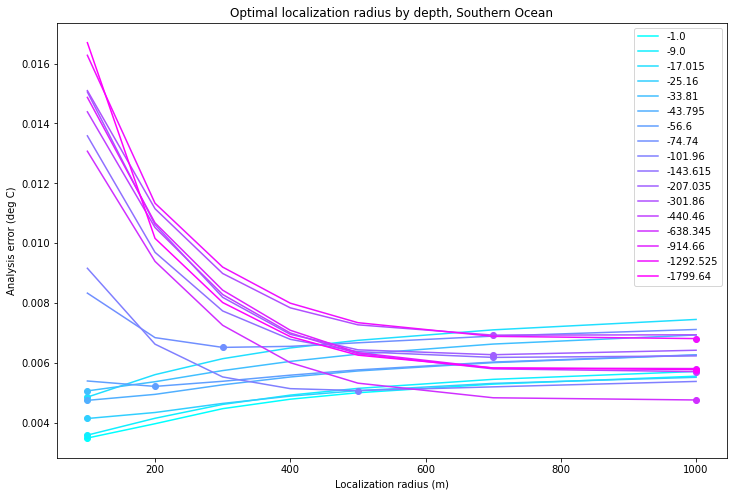

In [38]:
n = errs_m[:,::2].shape[1]
colors = plt.cm.cool(np.linspace(0,1,n))

for i in range(n):
    plt.plot(loc_rads_m, errs_m[:, 2*i], color=colors[i], label=ocn_z[inds[2*i]])
    min_ind = np.argmin(errs_m[:, 2*i])
    plt.plot(loc_rads_m[min_ind], errs_m[min_ind, 2*i], 'o', color=colors[i])
plt.legend(loc='upper right')

# Labels
plt.xlabel('Localization radius (m)')
plt.ylabel('Analysis error (deg C)')
plt.title('Optimal localization radius by depth, '+this_full_name)

# Save and show
plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/analysis_err_vs_loc_rad_by_depth_ocn_'+this_short_name)
plt.show()

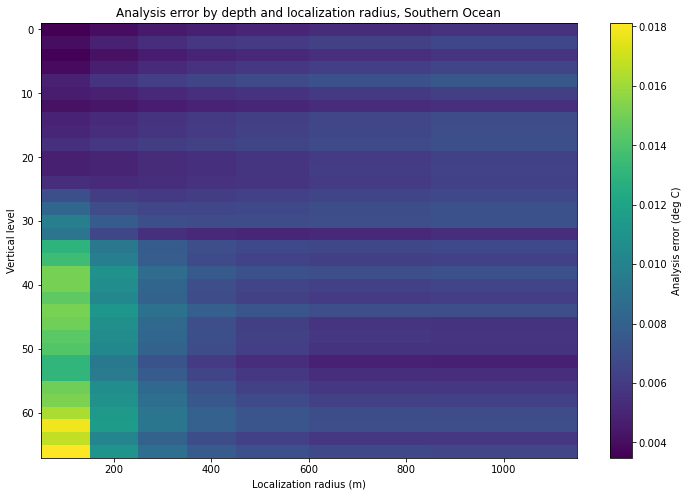

In [21]:
# Plot errors
ax = plt.axes()
im = plt.pcolormesh(loc_rads_m, inds, errs_m.transpose())
cbar = plt.colorbar(im)
cbar.set_label('Analysis error (deg C)')
ax.invert_yaxis()

# Labels
ax.set_title('Analysis error by depth and localization radius, '+this_full_name)
ax.set_xlabel('Localization radius (m)')
ax.set_ylabel('Vertical level')

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/analysis_err_vs_loc_rad_by_depth_pcolor_ocn_'+this_short_name)
plt.show()

In [22]:
# Find optimal localization radius
optimal_loc_rad_m = [loc_rads_m[ii] for ii in np.argmin(errs_m, axis=0)]

In [23]:
best_single_loc_rad_ind_m = np.argmin(np.mean(errs_m, axis=1))
best_single_loc_rad_m = loc_rads_m[best_single_loc_rad_ind_m]

In [24]:
# Save distances with correlations greater than some cutoff
cutoff = 0.5
dist_cutoff = dist_mat.copy()
dist_cutoff[this_cor[:this_ind, :this_ind]<cutoff] = None

In [25]:
# Compute correlation length scale
corr_length = np.empty(this_ind)
for ii in range(this_ind):
    corr_length[ii] = np.nanmax(dist_cutoff[ii,:])

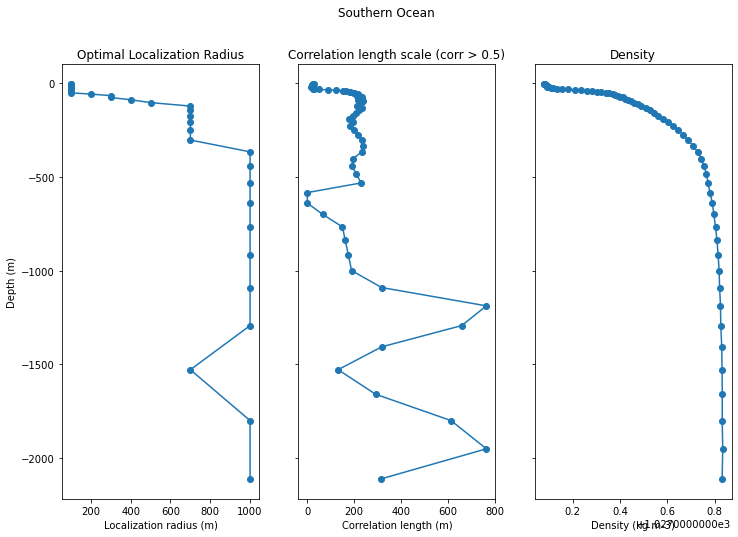

In [26]:
## Create subplots
fig, axs = plt.subplots(ncols=3, sharey=True) 

# Plots
axs[0].plot(optimal_loc_rad_m, ocn_z[inds], '-o')
axs[1].plot(corr_length, ocn_z[:this_ind], '-o')
axs[2].plot(ocn_rho[:this_ind], ocn_z[:this_ind], '-o')

# Labels
axs[0].set_ylabel('Depth (m)')
axs[0].set_title('Optimal Localization Radius')
axs[1].set_title('Correlation length scale (corr > 0.5)')
axs[2].set_title('Density')
axs[0].set_xlabel('Localization radius (m)')
axs[1].set_xlabel('Correlation length (m)')
axs[2].set_xlabel('Density (kg m-3)')
plt.suptitle(this_full_name)

# Save and show
plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/opt_loc_rad_by_depth_ocn_'+this_short_name)
plt.show()

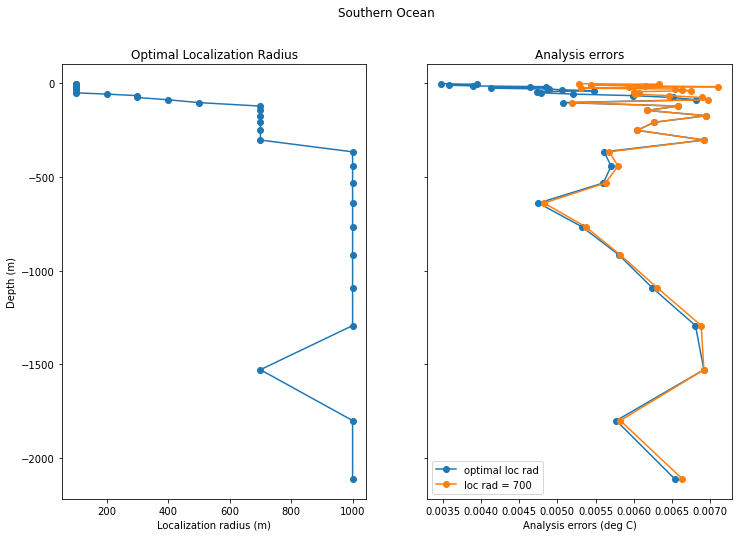

In [27]:
## Create subplots
fig, axs = plt.subplots(ncols=2, sharey=True) 

# Plots
axs[0].plot(optimal_loc_rad_m, ocn_z[inds], '-o')
axs[1].plot(np.min(errs_m, axis=0), ocn_z[inds], '-o', label='optimal loc rad')
axs[1].plot(errs_m[best_single_loc_rad_ind_m,:], ocn_z[inds], '-o', label='loc rad = '+str(best_single_loc_rad_m))

# Labels
axs[0].set_ylabel('Depth (m)')
axs[0].set_title('Optimal Localization Radius')
axs[1].set_title('Analysis errors')
axs[0].set_xlabel('Localization radius (m)')
axs[1].set_xlabel('Analysis errors (deg C)')
axs[1].legend()
plt.suptitle(this_full_name)

# Save and show
plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/opt_vs_single_loc_rad_by_depth_ocn_'+this_short_name)
plt.show()

In [28]:
## Redo optimal localization calculation with density coordinates
loc_rads_rho = [0.1, 0.3, 0.5, 0.7, 1, 1.5, 2, 2.5, 3, 3.5]
num_loc_rads_rho = len(loc_rads_rho)

In [29]:
errs_rho = np.empty([num_loc_rads_rho, num_inds])
for vertical_ind in range(num_inds):
    errs_rho[:, vertical_ind] = run_multiple_trials(observe_this_level=vertical_ind, localization_radii=loc_rads_rho, this_cov=this_cov, this_cov_sqrt=this_cov_sqrt, pos_state=ocn_rho, num_trials=100, stop=this_ind)

/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts/letkf.py:120: RuntimeWarning: invalid value encountered in reciprocal
  evals_inv = np.reciprocal(evals)


In [30]:
# Find optimal localization radius
optimal_loc_rad_rho = [loc_rads_rho[ii] for ii in np.argmin(errs_rho, axis=0)]

In [31]:
best_single_loc_rad_ind_rho = np.argmin(np.mean(errs_rho, axis=1))
best_single_loc_rad_rho = loc_rads_rho[best_single_loc_rad_ind_rho]

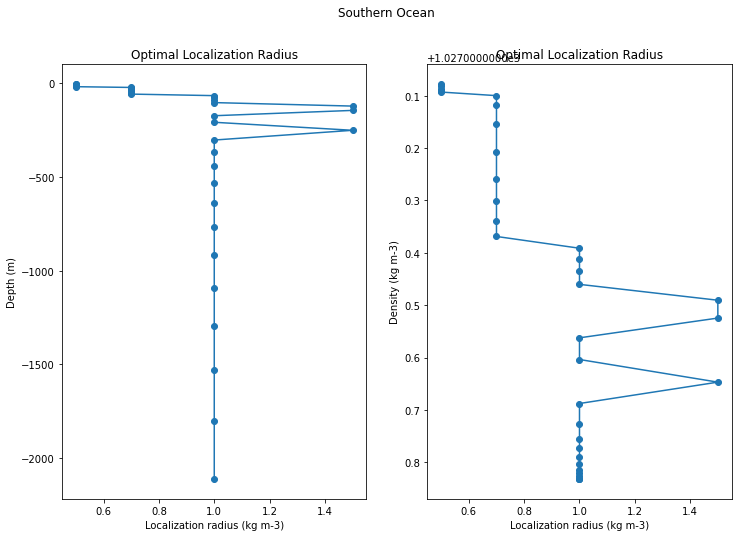

In [32]:
## Create subplots
fig, axs = plt.subplots(ncols=2) 

# Plots
axs[0].plot(optimal_loc_rad_rho, ocn_z[inds], '-o')
axs[1].plot(optimal_loc_rad_rho, ocn_rho[inds], '-o')
axs[1].invert_yaxis()

# Labels
axs[0].set_ylabel('Depth (m)')
axs[1].set_ylabel('Density (kg m-3)')
axs[0].set_title('Optimal Localization Radius')
axs[1].set_title('Optimal Localization Radius')
axs[0].set_xlabel('Localization radius (kg m-3)')
axs[1].set_xlabel('Localization radius (kg m-3)')
plt.suptitle(this_full_name)

# Save and show
plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/opt_loc_rad_by_density_ocn_'+this_short_name)
plt.show()

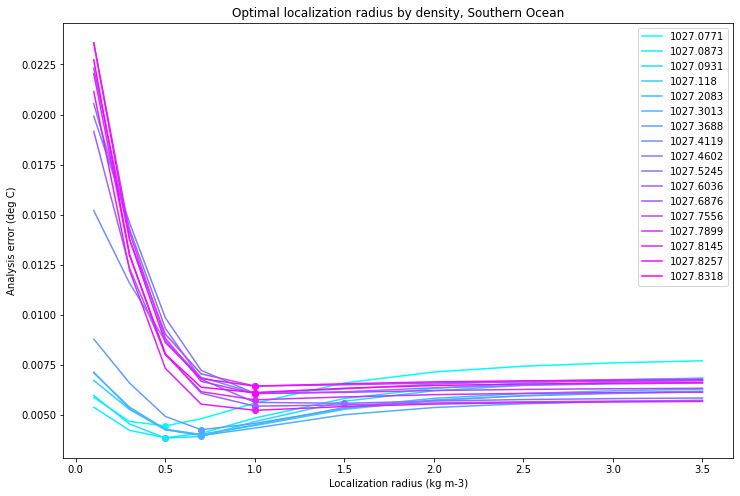

In [33]:
n = errs_rho[:,::2].shape[1]
colors = plt.cm.cool(np.linspace(0,1,n))

for i in range(n):
    plt.plot(loc_rads_rho, errs_rho[:, 2*i], color=colors[i], label=ocn_rho[inds[2*i]])
    min_ind = np.argmin(errs_rho[:, 2*i])
    plt.plot(loc_rads_rho[min_ind], errs_rho[min_ind, 2*i], 'o', color=colors[i])
plt.legend(loc='upper right')

# Labels
plt.xlabel('Localization radius (kg m-3)')
plt.ylabel('Analysis error (deg C)')
plt.title('Optimal localization radius by density, '+this_full_name)

# Save and show
plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/analysis_err_vs_loc_rad_by_density_ocn_'+this_short_name)
plt.show()

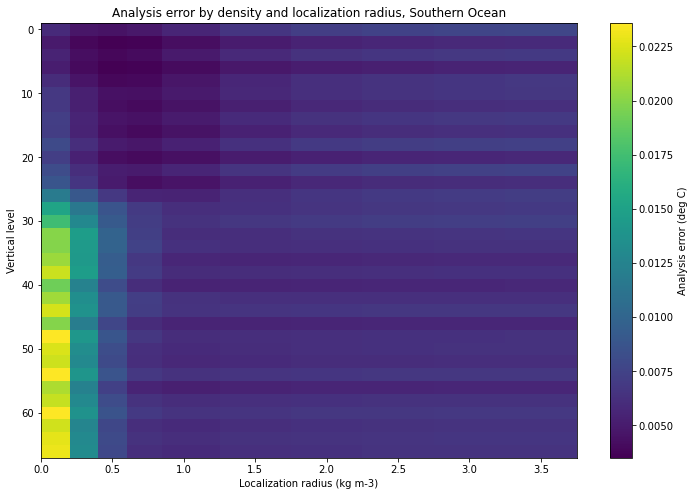

In [34]:
# Plot errors
ax = plt.axes()
im = plt.pcolormesh(loc_rads_rho, inds, errs_rho.transpose())
cbar = plt.colorbar(im)
cbar.set_label('Analysis error (deg C)')
ax.invert_yaxis()

# Labels
ax.set_title('Analysis error by density and localization radius, '+this_full_name)
ax.set_xlabel('Localization radius (kg m-3)')
ax.set_ylabel('Vertical level')

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/analysis_err_vs_loc_rad_by_density_pcolor_ocn_'+this_short_name)
plt.show()

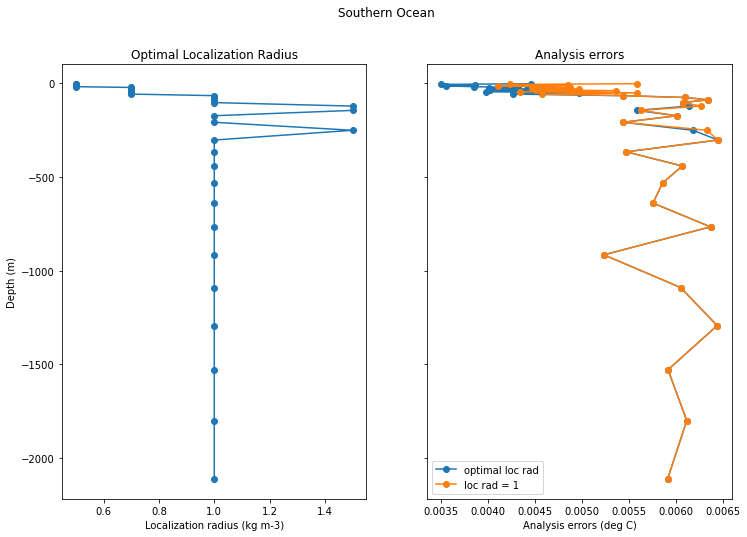

In [35]:
## Create subplots
fig, axs = plt.subplots(ncols=2, sharey=True) 

# Plots
axs[0].plot(optimal_loc_rad_rho, ocn_z[inds], '-o')
axs[1].plot(np.min(errs_rho, axis=0), ocn_z[inds], '-o', label='optimal loc rad')
axs[1].plot(errs_rho[best_single_loc_rad_ind_rho,:], ocn_z[inds], '-o', label='loc rad = '+str(best_single_loc_rad_rho))

# Labels
axs[0].set_ylabel('Depth (m)')
axs[0].set_title('Optimal Localization Radius')
axs[1].set_title('Analysis errors')
axs[0].set_xlabel('Localization radius (kg m-3)')
axs[1].set_xlabel('Analysis errors (deg C)')
axs[1].legend()
plt.suptitle(this_full_name)

# Save and show
plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/opt_vs_single_loc_rad_by_density_ocn_'+this_short_name)
plt.show()

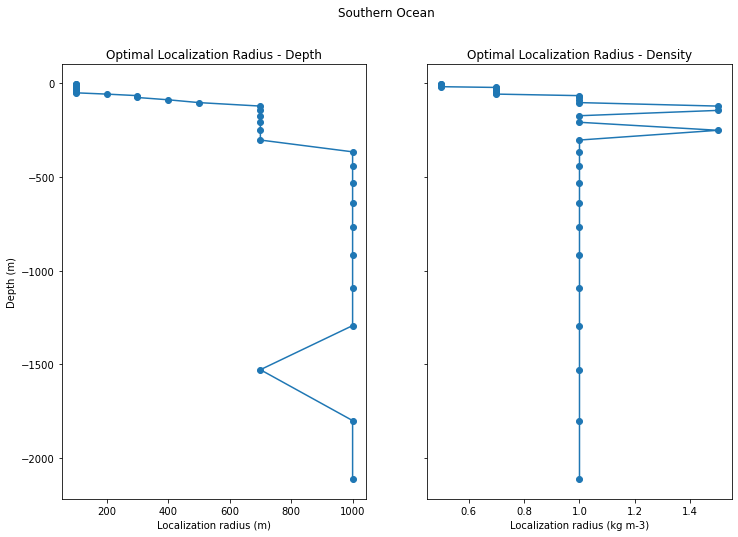

In [36]:
## Create subplots
fig, axs = plt.subplots(ncols=2, sharey=True) 

# Plots
axs[0].plot(optimal_loc_rad_m, ocn_z[inds], '-o')
axs[1].plot(optimal_loc_rad_rho, ocn_z[inds], '-o')

# Labels
axs[0].set_ylabel('Depth (m)')
axs[0].set_title('Optimal Localization Radius - Depth')
axs[1].set_title('Optimal Localization Radius - Density')
axs[0].set_xlabel('Localization radius (m)')
axs[1].set_xlabel('Localization radius (kg m-3)')
plt.suptitle(this_full_name)

# Save and show
plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/opt_loc_rad_by_depth_and_density_ocn_'+this_short_name)
plt.show()

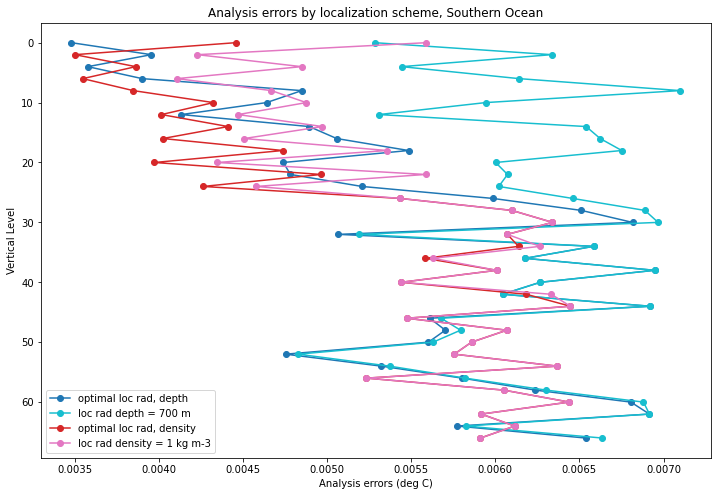

In [37]:
# Plot
ax = plt.axes()
plt.plot(np.min(errs_m, axis=0), inds, '-o', label='optimal loc rad, depth', color='tab:blue')
plt.plot(errs_m[best_single_loc_rad_ind_m,:], inds, '-o', label='loc rad depth = '+str(best_single_loc_rad_m)+' m', color='tab:cyan')
plt.plot(np.min(errs_rho, axis=0), inds, '-o', label='optimal loc rad, density', color='tab:red')
plt.plot(errs_rho[best_single_loc_rad_ind_rho,:], inds, '-o', label='loc rad density = '+str(best_single_loc_rad_rho)+' kg m-3', color='tab:pink')
ax.invert_yaxis()

# Labels
ax.legend()
ax.set_ylabel('Vertical Level')
ax.set_title('Analysis errors by localization scheme, '+this_full_name)
ax.set_xlabel('Analysis errors (deg C)')

# Save and show
plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/analysis_errs_by_depth_and_density_ocn_'+this_short_name)
plt.show()